<a href="https://colab.research.google.com/github/Mayank-004/Covid-19-/blob/main/Covid19_Death_Predictive_Analysis_Imbalance_correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing 




## Importing the libraries

In [157]:
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
random.seed(786)
import time
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, plot_confusion_matrix, plot_roc_curve,precision_recall_curve



## Importing the dataset







In [158]:
url1 = '/content/drive/MyDrive/Colab Notebooks/Covid Dataset/covid.csv'
dataset = pd.read_csv(url1, error_bad_lines=False)


dataset.head(2)


,id,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
0,16169f,2,1,04-05-2020,02-05-2020,9999-99-99,97,2,27,97,2,2,2,2,2,2,2,2,2,2,2,1,97
1,1009bf,2,1,19-03-2020,17-03-2020,9999-99-99,97,2,24,97,2,2,2,2,2,2,2,2,2,2,99,1,97


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [159]:
dataset.describe()

,sex,patient_type,intubed,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
count,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000
mean,1.506726,1.215165,76.562952,1.846262,42.622483,50.400692,2.210633,2.280221,2.265029,2.319628,2.145774,2.410030,2.286157,2.138905,2.283765,2.238360,31.573034,1.728651,76.562864
std,0.499955,0.410937,39.058676,0.560939,16.659973,47.501579,5.683523,5.327832,5.334658,5.667381,5.459866,6.489959,5.438405,5.395578,5.393232,5.571901,45.082123,0.658710,39.059060
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,97.000000,2.000000,31.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,97.000000
50%,2.000000,1.000000,97.000000,2.000000,41.000000,97.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,97.000000
75%,2.000000,1.000000,97.000000,2.000000,53.000000,97.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,99.000000,2.000000,97.000000
max,2.000000,2.000000,99.000000,99.000000,120.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,99.000000,3.000000,99.000000


Filling missing values of Target column MOIC

In [160]:
# check missing value in dataset
missing = dataset.isna().sum().sort_values(ascending = False)
percent_missing = ((missing / dataset.isnull().count()) * 100).sort_values(ascending = False)
missing_df = pd.concat([missing,percent_missing], axis = 1, keys = ['Total', 'Percent'],sort = False)
missing_df[missing_df['Total'] >= 1]

,Total,Percent


In [161]:
dataset['death'] = dataset['date_died'].apply(lambda x: 1 if x == '9999-99-99' else 0)


In [162]:
# drop some unnecessary columns
dataset.drop(columns={"id","patient_type",
                 "entry_date","date_symptoms",
                 "date_died","pregnancy"}, axis=1, inplace=True)

In [163]:
dataset

,sex,intubed,pneumonia,age,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu,death
0,2,97,2,27,2,2,2,2,2,2,2,2,2,2,2,1,97,1
1,2,97,2,24,2,2,2,2,2,2,2,2,2,2,99,1,97,1
2,1,2,2,54,2,2,2,2,2,2,2,1,2,2,99,1,2,1
3,2,2,1,30,2,2,2,2,2,2,2,2,2,2,99,1,2,1
4,1,2,2,60,1,2,2,2,1,2,1,2,2,2,99,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566597,2,97,2,58,1,2,2,2,2,2,2,2,2,2,2,3,97,1
566598,1,97,2,48,2,2,2,2,2,2,2,2,2,2,2,3,97,1
566599,1,2,1,49,2,2,2,2,2,2,2,1,2,2,99,3,2,1
566600,1,97,1,43,2,2,2,2,2,2,2,2,2,2,2,3,97,1


In [164]:
# checking if dataset is balanced or imbalanced
dataset['death'].value_counts(normalize=True)

1    0.936153
0    0.063847
Name: death, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


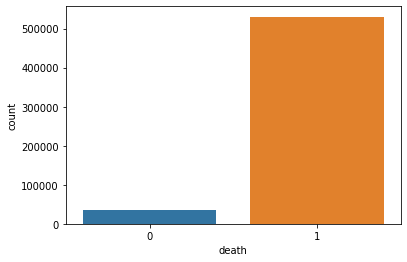

In [165]:
sn.countplot(dataset['death'])


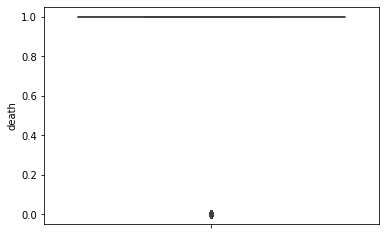

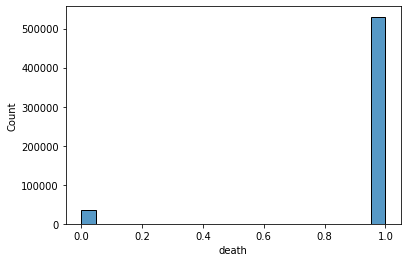

In [166]:
# check MOIC's distribution
import seaborn as sn

sn.boxplot(y=dataset["death"])
plt.show()
sn.histplot(dataset, x ='death')
plt.show()




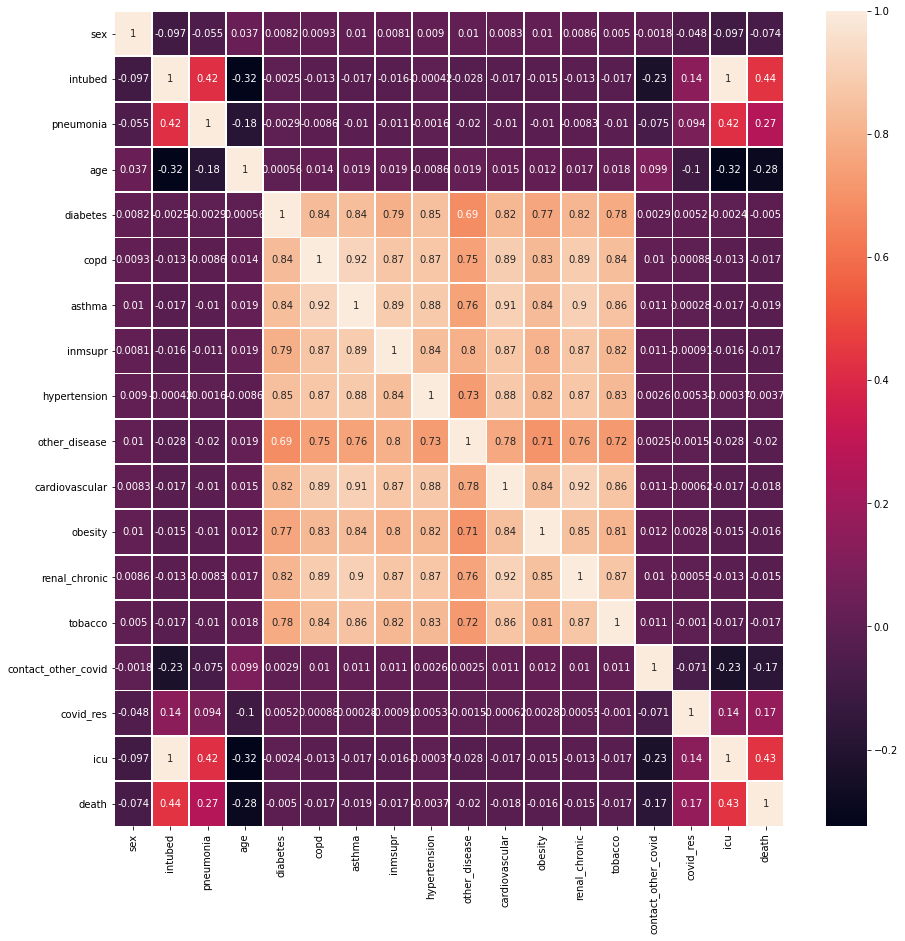

In [167]:
# Correlation Matrix
corrMatrix= dataset.corr()

fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches

sn.heatmap(corrMatrix, annot=True,linewidth=0.8)
plt.show()

In [168]:
X = dataset.loc[:,dataset.columns!='death']
Y = dataset['death']


In [27]:
X

,sex,intubed,pneumonia,age,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
0,2,97,2,27,2,2,2,2,2,2,2,2,2,2,2,1,97
1,2,97,2,24,2,2,2,2,2,2,2,2,2,2,99,1,97
2,1,2,2,54,2,2,2,2,2,2,2,1,2,2,99,1,2
3,2,2,1,30,2,2,2,2,2,2,2,2,2,2,99,1,2
4,1,2,2,60,1,2,2,2,1,2,1,2,2,2,99,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566597,2,97,2,58,1,2,2,2,2,2,2,2,2,2,2,3,97
566598,1,97,2,48,2,2,2,2,2,2,2,2,2,2,2,3,97
566599,1,2,1,49,2,2,2,2,2,2,2,1,2,2,99,3,2
566600,1,97,1,43,2,2,2,2,2,2,2,2,2,2,2,3,97


In [28]:
Y

0         1
1         1
2         1
3         1
4         0
         ..
566597    1
566598    1
566599    1
566600    1
566601    1
Name: death, Length: 566602, dtype: int64

## Splitting the dataset into the Training set and Test set

In [169]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 786, stratify=Y)

In [170]:
y_test

485398    1
198767    0
396584    1
203172    1
404884    1
         ..
191464    1
514161    1
393985    1
364155    1
400863    1
Name: death, Length: 169981, dtype: int64

### Building Models

Defining Function for Model Performance evaluation

In [222]:
# defining a reusable function to evaluate model performance

def eval_result(model_name,X_train,y_train,y_predtrain,X_test,y_test,y_predtest):

    from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, plot_confusion_matrix, plot_roc_curve
    from matplotlib import pyplot as plt

    train_accuracy = accuracy_score(y_train, y_predtrain)
    print(f'training data accuracy {train_accuracy}')
    #train_roc_auc = roc_auc_score(y_train, y_predtrain) 
    #print(f' Area under the ROC curve for training data {train_roc_auc}')
    plot_roc_curve(model_name, X_train, y_train)

    precision_recall_curve(y_train, y_predtrain)

    test_accuracy = accuracy_score(y_test, y_predtest)
    print(f'testing data accuracy {test_accuracy}')
    #test_roc_auc = roc_auc_score(y_test, y_predtest) 
    #print(f' Area under the ROC curve for testing data {test_roc_auc}')
    plot_roc_curve(model_name, X_test, y_test)
    
    precision_recall_curve(y_test, y_predtest)


    
    print(classification_report(y_test,y_predtest,digits=5))
    plot_confusion_matrix(model_name, X_test, y_test,cmap=plt.cm.pink, normalize = 'all')
  

In [181]:
def run_model(model,X_train,y_train,verbose=True):
    t0=time.time()
    if verbose== False:
        model.fit(X_train,y_train.ravel(),verbose=0)
    else :
        model.fit(X_train,y_train.ravel())
    
    time_taken= time.time()- t0
    print(f'Time taken: {time_taken}')

Random Forest

In [ ]:
# Hyperparameter Tuning
# run once

'''from sklearn.ensemble import RandomForestClassifier


n_estimators_hyp = [100,200,300,400,500,700,1000]
min_sample_leaf_hyp = np.linspace(1,20, 20);

oobscore_list=dict()

for i in n_estimators_hyp:
    for j in min_sample_leaf_hyp:
        model2 = RandomForestClassifier(n_estimators=i, min_samples_leaf=int(j), oob_score=True);
        model2.fit(X_train, y_train)
        key = "n_estimator =" +str(i)+" min_sample_leaf ="+str(j);
        oobscore_list[key]=model2.oob_score_

    #oobscore_list.append(rf_model.oob_score_)

oobscore_list'''

In [235]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(criterion='gini', 
                             n_estimators=400,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1,
                            class_weight={0:9999,1:1})
#rf.fit(X_train, y_train.values)
run_model(rf,X_train,y_train)
print("%.4f" % rf.oob_score_)

Time taken: 171.16500806808472
0.8017


Predicting result

In [236]:
y_predtest_rf= rf.predict(X_test)
#y_score = rf.predict_proba(X_test)[:,1]

y_predtrain_rf = rf.predict(X_train)


In [76]:
#print(roc_auc_score(y_test, y_score))


0.9373761551848897


evaluating model performance

training data accuracy 0.8185244855920387
testing data accuracy 0.8036015790000058
              precision    recall  f1-score   support

           0    0.22120   0.82355   0.34873     10853
           1    0.98522   0.80224   0.88437    159128

    accuracy                        0.80360    169981
   macro avg    0.60321   0.81290   0.61655    169981
weighted avg    0.93644   0.80360   0.85017    169981



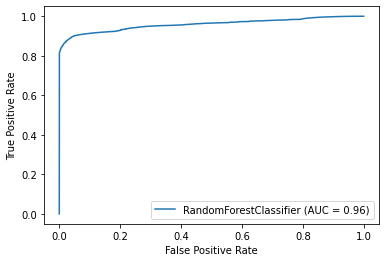

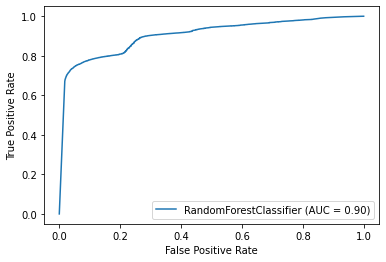

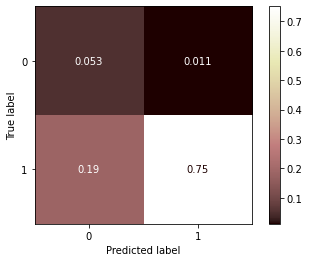

In [237]:
eval_result(rf,X_train,y_train,y_predtrain_rf,X_test,y_test,y_predtest_rf)

In [147]:
precision_recall_curve(y_train, y_predtrain_rf)

(array([0.66668821, 0.96908841, 1.        ]),
 array([1.        , 0.92739759, 0.        ]),
 array([0, 1]))

In [ ]:
# get importance
rf.feature_importances_


array([0.01352789, 0.18282423, 0.1118199 , 0.27583773, 0.02015345,
       0.01099423, 0.00828207, 0.01058627, 0.02071646, 0.01414788,
       0.01244461, 0.01828796, 0.01301372, 0.01539102, 0.05328348,
       0.0735605 , 0.14512858])

Text(0.5, 0, 'Random Forest Feature Importance')

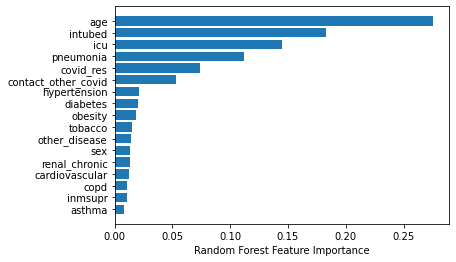

In [ ]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Random Forest with Oversampling

In [176]:
# define oversampling strategy
import imblearn
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy=0.5)

In [210]:
X

,sex,intubed,pneumonia,age,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
0,2,97,2,27,2,2,2,2,2,2,2,2,2,2,2,1,97
1,2,97,2,24,2,2,2,2,2,2,2,2,2,2,99,1,97
2,1,2,2,54,2,2,2,2,2,2,2,1,2,2,99,1,2
3,2,2,1,30,2,2,2,2,2,2,2,2,2,2,99,1,2
4,1,2,2,60,1,2,2,2,1,2,1,2,2,2,99,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566597,2,97,2,58,1,2,2,2,2,2,2,2,2,2,2,3,97
566598,1,97,2,48,2,2,2,2,2,2,2,2,2,2,2,3,97
566599,1,2,1,49,2,2,2,2,2,2,2,1,2,2,99,3,2
566600,1,97,1,43,2,2,2,2,2,2,2,2,2,2,2,3,97


In [211]:
X_over

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,2,97,2,27,2,2,2,2,2,2,2,2,2,2,2,1,97
1,2,97,2,24,2,2,2,2,2,2,2,2,2,2,99,1,97
2,1,2,2,54,2,2,2,2,2,2,2,1,2,2,99,1,2
3,2,2,1,30,2,2,2,2,2,2,2,2,2,2,99,1,2
4,1,2,2,60,1,2,2,2,1,2,1,2,2,2,99,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795634,2,2,1,36,2,2,2,2,1,2,2,1,1,2,99,1,2
795635,2,2,1,63,1,2,2,2,1,2,2,2,1,2,99,2,2
795636,1,2,1,62,1,2,2,2,2,2,2,1,2,2,1,1,2
795637,2,2,1,76,2,2,2,2,2,2,2,2,2,2,2,1,2


In [212]:

# fit and apply the transform
X_over, y_over = oversample.fit_resample(X, Y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [213]:
X_over=pd.DataFrame(X_over)
y_over=pd.DataFrame(y_over)

In [214]:
X_over

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,2,97,2,27,2,2,2,2,2,2,2,2,2,2,2,1,97
1,2,97,2,24,2,2,2,2,2,2,2,2,2,2,99,1,97
2,1,2,2,54,2,2,2,2,2,2,2,1,2,2,99,1,2
3,2,2,1,30,2,2,2,2,2,2,2,2,2,2,99,1,2
4,1,2,2,60,1,2,2,2,1,2,1,2,2,2,99,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795634,2,1,1,38,2,2,2,2,2,2,2,1,2,2,1,1,1
795635,1,2,1,91,1,2,2,2,2,2,2,2,2,2,1,1,2
795636,2,2,2,55,2,2,2,2,2,2,2,1,2,2,99,2,2
795637,2,2,1,69,2,2,2,2,1,2,2,1,2,2,99,2,2


In [215]:
y_over

,0
0,1
1,1
2,1
3,1
4,0
...,...
795634,0
795635,0
795636,0
795637,0


In [218]:
X_trainover, X_testover, y_trainover, y_testover = train_test_split(X_over, y_over, test_size = 0.3, random_state = 786,stratify=y_over)

In [219]:
X_testover

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
653271,2,1,1,59,2,2,2,2,2,2,2,2,2,2,2,1,2
91364,2,1,1,54,1,2,2,2,2,2,2,1,2,2,1,1,1
293979,2,97,2,33,2,2,2,2,2,2,2,2,2,2,1,2,97
254805,1,97,2,39,2,2,2,2,2,2,2,2,2,1,2,2,97
131044,1,97,2,41,2,2,2,2,2,2,2,2,2,2,99,1,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127252,1,97,2,28,2,2,2,2,2,2,2,2,2,2,99,1,97
189897,1,1,1,72,1,2,2,2,1,2,2,2,2,2,2,1,1
406074,1,97,2,43,2,2,2,2,2,2,2,2,2,2,1,2,97
28898,2,2,1,43,2,2,2,2,2,2,2,2,2,2,99,1,2


In [220]:
y_testover

,0
653271,0
91364,0
293979,1
254805,1
131044,1
...,...
127252,1
189897,1
406074,1
28898,0


In [221]:
from sklearn.ensemble import RandomForestClassifier
rf_Oversample = RandomForestClassifier(criterion='gini', 
                             n_estimators=400,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1,
                            #class_weight={0:9999,1:1}
                            )
rf_Oversample.fit(X_trainover, y_trainover)
#run_model(rf_Oversample,X_trainover,y_trainover)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=True, random_state=1, verbose=0,
                       warm_start=False)

In [201]:
y_trainover

,0
78548,1
655759,0
631187,0
447771,1
273348,1
...,...
323478,1
315678,1
515687,1
309450,1


In [223]:
y_predtest_rfover= rf_Oversample.predict(X_testover)
y_predtest_rfover=pd.DataFrame(y_predtest_rfover)

#y_score = rf.predict_proba(X_test)[:,1]

y_predtrain_rfover = rf_Oversample.predict(X_trainover)
y_predtrain_rfover=pd.DataFrame(y_predtrain_rfover)


training data accuracy 0.9357066291765643
testing data accuracy 0.9189583228595848
              precision    recall  f1-score   support

           0    0.83788   0.93845   0.88532     79564
           1    0.96726   0.90921   0.93734    159128

    accuracy                        0.91896    238692
   macro avg    0.90257   0.92383   0.91133    238692
weighted avg    0.92413   0.91896   0.92000    238692



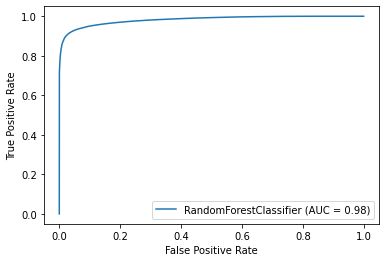

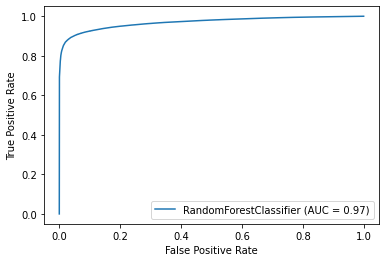

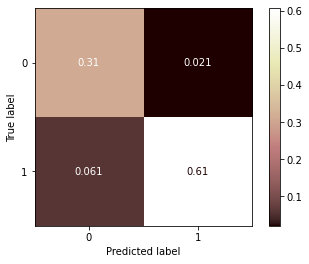

In [224]:
eval_result(rf_Oversample,X_trainover,y_trainover,y_predtrain_rfover,X_testover,y_testover,y_predtest_rfover)

In [198]:
y_trainover

,0
78548,1
655759,0
631187,0
447771,1
273348,1
...,...
323478,1
315678,1
515687,1
309450,1


In [205]:
y_predtrain_rfover=pd.DataFrame(y_predtrain_rfover)
y_predtrain_rfover

,0
0,1
1,0
2,0
3,1
4,1
...,...
556942,1
556943,1
556944,1
556945,1


###Random Forest with Undersampling

In [225]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy=0.5)

In [226]:
# fit and apply the transform
X_under, y_under = undersample.fit_resample(X, Y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [129]:
'''X_under=pd.DataFrame(X_under)
y_under=pd.DataFrame(y_under)'''

In [227]:
X_trainunder, X_testunder, y_trainunder, y_testunder = train_test_split(X_under, y_under, test_size = 0.3, random_state = 786)

In [230]:
from sklearn.ensemble import RandomForestClassifier
rf_undersample = RandomForestClassifier(criterion='gini', 
                             n_estimators=400,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1,
                            #class_weight={0:9999,1:1}
                            )
#rf.fit(X_train, y_train.values)
run_model(rf_undersample,X_trainunder,y_trainunder)

Time taken: 23.310018062591553


In [232]:
y_predtest_rfund= rf_undersample.predict(X_testunder)
#y_score = rf.predict_proba(X_test)[:,1]

y_predtrain_rfund = rf_undersample.predict(X_trainunder)


training data accuracy 0.9200331714251866
testing data accuracy 0.8811695690899598
              precision    recall  f1-score   support

           0    0.79301   0.86982   0.82964     10831
           1    0.93181   0.88683   0.90877     21728

    accuracy                        0.88117     32559
   macro avg    0.86241   0.87832   0.86920     32559
weighted avg    0.88564   0.88117   0.88244     32559



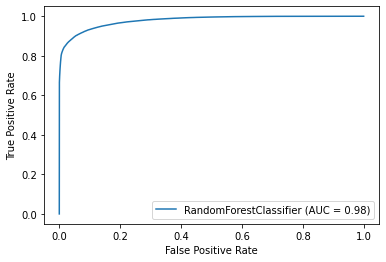

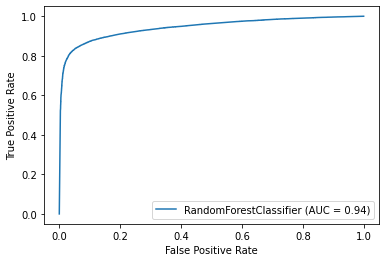

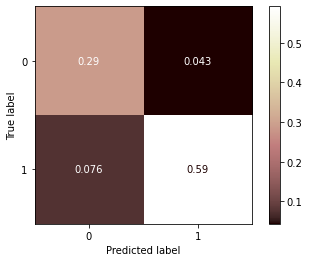

In [234]:
eval_result(rf_undersample,X_trainunder,y_trainunder,y_predtrain_rfund,X_testunder,y_testunder,y_predtest_rfund)